<a href="https://colab.research.google.com/github/wbwatkinson/AFIT-RI-MLBC/blob/main/demo_RFECV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This tutorial developed by W. Blair Watkinson II
# Apr 30, 2021

# Developed in support of education and research activities at 
# the Air Force Institute of Technology and the CSCE 623
# Machine Learning course

# For changes or questions, contact warren.watkinson@afit.edu

# MIT License

# Copyright (c) 2021 W. Blair Watkinson II

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Recursive Feature Elimination Cross-Validation

This tutorial introduces and provides an example of the [recursive feature elimination cross-validation](https://scikit-learn.org/stable/modules/feature_selection.html#rfe) (RFECV) available in the scikit-learn library. As the API states, RFECV attempts to eliminate features by recursively evaluating  models on increasingly smaller sets of features, pruning features on the basis of a cross-validation technique.

This tutorial demonstrates this technique on regression data.

## Generate regression data

We will begin by generating regression data using the scikit-learn function [`make_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html).

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression

from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# initialize random state and regression parameters
random_state = np.random.RandomState(101)
n_features = 25
bias_data = 0
noise = 0

# Build a regression task using 5 informative features
X, y, coef_data = make_regression(n_samples=2000, 
                                  n_features=n_features, n_informative=5, 
                                  bias=bias_data, noise=noise,
                                  random_state=random_state, coef=True)

We make use of several `make_regression` parameters to generate 2,000 observations, with 25 features, 5 of which are meaningful, a bias set to 0 and no noise. Furthermore, we initialize the function with a random state so that we have repeatable results in subsequent runs.

`make_regression` returns normally two values: the features of each observation, typically stored in a variable, `X`, and the scalar targets, often stored in a variable `y`. When the parameter `coef=True`, the function also returns the coefficients used to generate the data. We store these coefficients in a variabled named `coef_data`.

Let's output each of the values returned by the function and take a closer look.

In [ ]:
display(md('X as DataFrame'), pd.DataFrame(X))
display(md('y as DataFrame'), pd.DataFrame(y))
print(coef_data.shape)
display(pd.DataFrame(coef_data).T)

X as DataFrame

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,-0.843834,-0.410294,-1.196782,0.436798,1.503077,0.424673,0.074169,-1.559165,-0.000379,-0.488479,-0.994440,1.551669,-1.021955,0.980496,0.025692,1.580628,-0.491748,-0.524451,2.009966,0.345295,0.666001,-0.229391,1.115320,-0.381394,0.602541
1,-0.641526,0.433835,-1.869507,-0.776017,-1.544608,-0.231568,1.220733,0.676845,-0.708872,-2.005602,0.655392,1.030248,0.578181,-0.582272,-1.042384,-0.918550,0.986360,-1.377514,-0.117302,0.336510,-0.785831,1.457723,-0.502454,-0.620286,1.413874
2,-0.374288,-1.270314,-1.234401,-0.793723,0.496995,-0.047091,0.568538,-1.634498,-0.695832,-0.919414,-1.126115,-0.490537,1.117604,0.564404,-0.695959,0.735602,-1.289998,0.727146,0.508946,-1.030554,0.157775,-1.218867,0.766482,-0.102518,-0.972756
3,-1.134057,-0.722910,-0.313644,0.886168,1.488920,0.032794,-1.120367,-1.396319,0.145845,0.586746,0.861984,0.663009,-0.807366,0.100099,0.090265,0.794325,-0.223875,-0.051462,0.074972,-1.209161,1.911764,-1.696726,0.510846,1.230865,-0.722755
4,0.897062,0.156957,-0.989660,-0.230854,-1.307015,-0.013356,-0.640071,2.086111,-0.321653,0.017935,0.235261,0.326277,-1.515067,0.299177,0.985163,-0.571332,0.842621,1.512583,0.182130,-0.940782,-0.963421,0.067205,-0.003770,-1.113764,2.064858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.339074,0.463796,1.044229,0.740197,-0.354603,0.546551,-0.125465,-0.377200,-0.709162,-0.466442,1.757713,0.016873,0.556241,0.830889,2.155017,-0.342475,-0.180553,-1.344782,-1.015904,-0.077580,0.457150,0.055666,-1.570692,-1.786933,2.450999
1996,1.440640,1.565895,-0.662720,-0.227291,1.267231,-0.745855,0.999822,-0.520636,-0.311565,-0.258695,0.671525,-1.342860,1.838952,-0.284151,-0.527476,0.691429,0.602672,0.818191,-0.062796,0.897166,-0.384920,-0.577895,-0.079412,-0.142702,0.428989
1997,-0.144748,-1.380791,1.140207,0.327529,-0.498917,-0.449012,2.369546,0.476677,0.737809,0.535313,-0.031785,1.045618,-0.047262,-0.403741,0.324979,1.042374,-0.898164,-0.605100,0.928855,-0.818807,-0.072491,-0.566995,0.072167,-0.418334,1.229736
1998,-0.052053,0.808139,-1.085524,-1.061843,-0.191446,-1.453084,-1.600183,-1.275456,-0.935200,-0.607658,-0.369657,-1.057874,0.660948,-0.071986,-0.805490,1.096199,-0.136403,-0.861869,2.337572,0.937994,0.858620,2.037669,1.339166,-1.739121,0.421239


y as DataFrame

,0
0,140.084881
1,32.395905
2,-51.104806
3,112.122479
4,-3.265492
...,...
1995,54.501984
1996,33.353311
1997,97.292712
1998,16.133070


(25,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.0,15.251797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.804161,52.695668,0.0,0.0,0.0,69.126409,8.356917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As expected, `X` is a 2000 x 25 array representing the 25 features of 2000 observations. `y` is a 2000 x 1 array representing the targets of each observation. The most interesting value is `coef_data`, which is a 1d 25 element array. We display `coef_data` as a DataFrame and transform it to represent it in the same dimensions as `X`. These are the coefficients for each feature in `X` used to generate the data.

Note that most of the coefficients are 0. In fact, only 5 are not 0, consistent with our `make_regression` parameters. From `coef_data`, we see that only the 2nd, 11th, 12th, 16th, and 17th features are used to generate the data. This `coef_data` will allow us to compare the performance of our model with the original dataset, though we note that normally, we would not know the signal that generated the data. Indeed, this is why we use a tool like machine learning architectures to create models of observed behavior.

In [ ]:
# create feature names -- these are generic feature names x_1, x_2, ..., x_25
feature_names = np.array([f'x_{{{idx+1}}}' for idx in range(n_features)])

In the above cell, we created an array of feature names in the format $x_1, x_2, \dots, x_{25}$. This array will be useful for displaying various statistics related to our features.

## Sequester test data

Before we conduct any analysis on our data, we will sequester test data from our training data. For this, we use the [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function in the `scikit-learn` library.

For our purposes, we choose to use 20% of our data for test data, and we will reuse the random state we initialized above.

In [ ]:
from sklearn.model_selection import train_test_split

# split and sequester test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

## Analyze Data

Having removed our test data, let's turn to a brief analysis of our training data. A typical analysis will be much more thorough, but for our tutorial purposes we'll look briefly at only a histogram of each `X` feature and a correlation plot. 

One note about pairs plots, which we will not use, here. With 25 features and 2000 data points it will take several minutes to complete. Also, when conducting a pairs plot, we need to be certain to include the `y` target features to specifically evaluate the correlation between each `X` feature and `y`.

First, we'll take a look at a simple histogram of each `X` feature as well as the `y` targets.

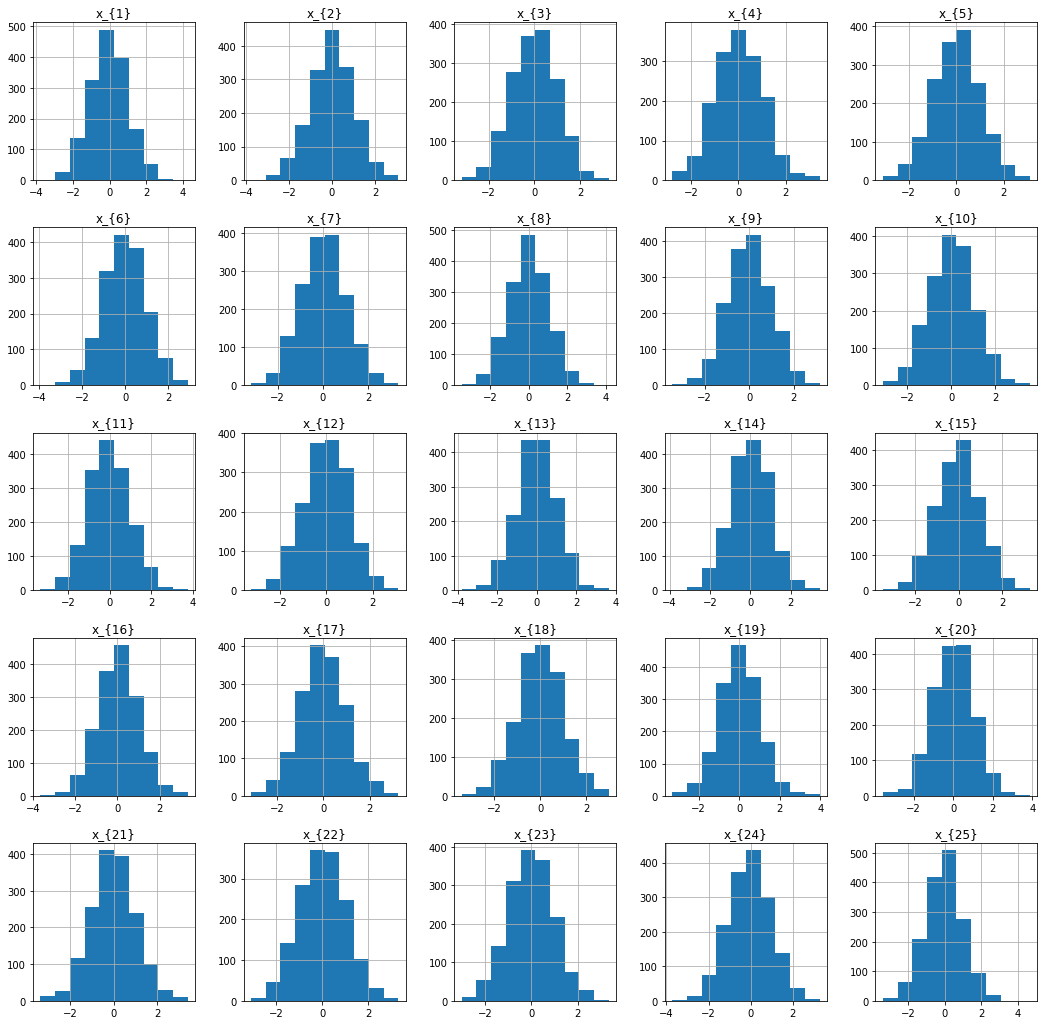

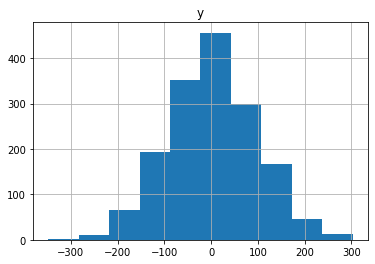

In [ ]:
import matplotlib.pyplot as plt

pd.DataFrame(X_train, columns=feature_names).hist(layout=(5,5), figsize=(18,18))
plt.show()

pd.DataFrame(y_train, columns=['y']).hist()
plt.show()

We'll also plot the pairwise correlation values in a heatmap using `pandas` `corr` function. Correlation values indicate the relative correlation between two series over the range $[-1.0, 1.0]$ with -1.0 representing two series that are perfectly negatively correlated and 1.0 representing perfect positive correlation. Zero values indicate pairs with no correlation.

To establish a constant color gradient, we set `vmin` and `vmax` to the possible range of correlation values $[-1.0, 1.0]$ instead of the default, which will use the actual data 

In [ ]:
# Create a DataFrame of X features and y target
df = pd.DataFrame(X_train, columns = feature_names)
df['y'] = y_train

# plot correlation to identify features which are highly correlated or 
# which might be important in determining y
corr = df.corr()

with pd.option_context('precision', 2):
    display(corr.style.background_gradient(vmin=-1.0, vmax=1.0, cmap='bwr'))

,x_{1},x_{2},x_{3},x_{4},x_{5},x_{6},x_{7},x_{8},x_{9},x_{10},x_{11},x_{12},x_{13},x_{14},x_{15},x_{16},x_{17},x_{18},x_{19},x_{20},x_{21},x_{22},x_{23},x_{24},x_{25},y
x_{1},1.00,-0.01,0.05,0.01,-0.01,0.06,0.00,-0.03,-0.02,0.00,-0.00,-0.03,0.01,-0.02,-0.02,-0.03,-0.03,-0.03,0.02,0.02,-0.00,-0.01,-0.00,-0.02,0.02,-0.04
x_{2},-0.01,1.00,0.01,-0.04,0.01,0.03,-0.03,0.04,0.02,0.02,-0.02,-0.02,0.02,-0.02,0.01,-0.00,-0.01,0.02,0.03,-0.01,-0.02,-0.02,0.01,-0.01,-0.01,0.14
x_{3},0.05,0.01,1.00,0.02,0.02,0.01,0.01,0.02,0.01,0.03,0.03,-0.01,-0.02,0.01,0.05,-0.00,-0.04,-0.00,-0.01,-0.01,0.00,-0.01,-0.02,0.04,0.01,0.00
x_{4},0.01,-0.04,0.02,1.00,0.00,-0.01,-0.01,0.01,-0.02,-0.03,0.04,0.05,-0.03,0.01,-0.01,0.00,0.00,0.01,-0.01,-0.03,0.01,-0.04,-0.01,0.00,-0.00,0.04
x_{5},-0.01,0.01,0.02,0.00,1.00,-0.05,0.02,-0.01,0.00,-0.06,0.00,0.01,-0.01,0.03,-0.02,0.01,0.03,0.03,0.06,0.01,-0.01,-0.02,0.02,-0.01,-0.00,0.01
x_{6},0.06,0.03,0.01,-0.01,-0.05,1.00,0.01,0.01,-0.03,0.02,-0.04,0.08,0.05,-0.04,0.01,-0.01,-0.01,-0.02,-0.04,0.02,-0.01,-0.05,-0.02,0.01,0.00,0.02
x_{7},0.00,-0.03,0.01,-0.01,0.02,0.01,1.00,-0.03,0.03,0.01,0.00,0.01,0.02,-0.01,-0.05,0.02,0.05,-0.02,-0.04,-0.04,0.04,-0.04,-0.02,0.01,0.04,0.02
x_{8},-0.03,0.04,0.02,0.01,-0.01,0.01,-0.03,1.00,-0.01,-0.04,0.03,-0.03,-0.01,-0.00,0.05,0.01,0.01,0.03,0.00,-0.00,-0.01,-0.02,-0.04,-0.04,-0.00,0.01
x_{9},-0.02,0.02,0.01,-0.02,0.00,-0.03,0.03,-0.01,1.00,-0.03,-0.02,-0.02,0.05,-0.00,0.02,-0.03,0.03,0.03,-0.01,-0.01,-0.01,0.01,0.02,-0.03,-0.03,-0.04
x_{10},0.00,0.02,0.03,-0.03,-0.06,0.02,0.01,-0.04,-0.03,1.00,-0.05,-0.01,-0.02,-0.05,0.01,0.00,0.04,-0.04,-0.01,0.01,0.00,0.03,0.03,0.01,-0.01,-0.02


This correlation heat map indicates that features $x_{16}$, $x_{12}$, $x_{11}$, $x_2$, $x_{17}$, $x_{15}$, in order of decreasing importance, are correlated with $y$. Other features of equal but relatively low importance include $x_{1}$, $x_{4}$, $x_{9}$, $x_{19}$, and $x_{20}$, each with a correlation value of either 0.04 or -0.04.

## Scale and transform data

At this point, it would be appropriate to scale both our input `X` and output `y` values. However, we will not actually scale our features because, as an exercise in curiousity, we want to observe how closely we can reproduce the original signal that generated the data. If we were to scale and transform our data, the model we create will be accurate for scaled and transformed data, not the original data. Since the `make_regression` function above actually provides us with the coefficients used to generate the data, assuming we can accurately generate a model that fits the original data, we can compare that model to the model that generated the data.

Nonetheless, it does appear that each of our `X` features has a mean of approximately 0 and a unit variance.



## Conduct recursive feature elimination

We're ready to begin feature elimination! `scikit-learn` provides the `RFECV` method to help us.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold

linear = LinearRegression()
min_features_to_select = 1

# create the RFE object and compute a cross-validated score.
rfecv = RFECV(estimator=linear, step=1, 
              cv=RepeatedKFold(n_splits=10, n_repeats=5, random_state=random_state),
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features_to_select)

For our purposes, we use a `LinearRegression` estimator and the `RepeatedKFold` cross-validation iterator to generate 5 trials of 10-fold cross-validation. We continue to use our `random_state` variable for reproducibility. We use the `neg_mean_squared_error` scoring metric for cross-validation and demand that we include at least one feature in our final model.

The `RFECV` object has several useful methods and properties that we will use in the following steps:

- Methods
  - `fit()` will fit the model created by recursive feature elimination to the data.

- Properties
  - `grid_scores_` provides a numpy array of cross-validation scores for models of increasing features.
  - `n_features_` provides the count of the minimum number features use to generate the model with the least cross-validated error

## Train model

We will use the `fit` method to train our model.

In [ ]:
rfecv.fit(X_train, y_train);

## Analyze model

We will attempt to analyze our model using several visual and mathematical tools.

### MSE of models by feature

First, let us examine the effect of increasing features on the mean squared error, also known as a spaghetti plot. Since we used the negated mean squared error scores for cross-validation, we display the negated scores along the y-axis in order to display the scores on the positive axis, as expected. We plot the results along the x-axis.

From the plot, it appears that 5 features is the minimal number of features required to minimize error.

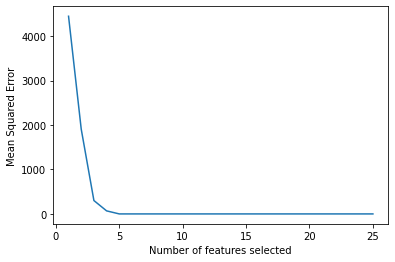

In [ ]:
import matplotlib.pyplot as plt

# plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean Squared Error")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         -rfecv.grid_scores_)
plt.show()

### Number of features selected by RFECV

We can alternatively assess the appropriate number of features using the `n_features_` property.

In [ ]:
display(md(f'Optimal number of features: {rfecv.n_features_}'))

Optimal number of features: 8

Somewhat unexpectedly, according to the `n_features_` parameter, RFECV identified 8 optimal features (if you don't see 8, restart the Jupyter kernel and run all cells). We can explore further by using `support_` property.

In [ ]:
display(md(f'Features of interest: {rfecv.support_}'))
display(md(f'Total number features of interest: {rfecv.support_.sum()}' ))
print(np.array(range(1,26)))
display(md(f'Features of interest: {feature_names[rfecv.support_]}'))

Features of interest: [False  True False False  True False False False False False  True  True
 False False False  True  True False  True False False False False False
  True]

Total number features of interest: 8

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


Features of interest: ['x_{2}' 'x_{5}' 'x_{11}' 'x_{12}' 'x_{16}' 'x_{17}' 'x_{19}' 'x_{25}']

The `RFECV` object's `support_` property is an array of `True`/`False` values indicating whether that feature is used in RFECV optimal model. When we filter our `feature_names` array with the `support_` property, we note that 6 of the 8 features, namely, $x_2$, $x_{11}$, $x_{12}$, $x_{16}$, $x_{17}$, and $x_{19}$, correspond with the features we noted in our correlation analysis above, but two of the features, $x_5$ and $x_{25}$, did not appear to have a strong relationship with `y` (0.01 and 0.02, respectively).

### Model explainability

We can gain additional insight as well as model explainability by actually displaying the model generated by RFECV. Doing this allows us to see the relative importance of each feature to the target value.

To support this, we will first create a helper function 
```
generate_model_function(beta0, betas, feature_names)
```
where `beta0` is the bias of the function, `betas` is the array of coefficients, and `feature_names` is an array of the names of each feature. The function returns a string representing the model function in the form $y = \beta_0 + \beta_1x_1 + \dots + \beta_nx_n$ for $n$ features.

In [ ]:
def generate_model_function(beta0, betas, feature_names):
    if np.isclose(beta0, 0):
        model_function = f'$y = '
    else:
        model_function = f'$y = {beta0:.3f} + '

    for beta, feature_name in zip(betas, feature_names):
        model_function += f'{beta:.3f}{feature_name} + '
    
    return model_function[:-3] + '$'

Now, we'll use our helper function to generate the algabraic representation of our model. Below, we reuse the technique of filtering our column names array with the `support_` property and store the result in `selected_feature_names`. The end result is that `selected_feature_names` is an array of feature names used in the `RFECV` model.

When we call our `generate_model_function`, we use the `estimator_` property of the `RFECV` object. In this case, the estimator is a linear regression model. The `LinearRegression` class includes the `intercept_` and `coef_` properties containing the $b_0$ and $b_1, \dots, b_n$ coefficients, respectively.

In [ ]:
# for explainability, report the trained model
selected_feature_names = feature_names[rfecv.support_]

display(md(generate_model_function(rfecv.estimator_.intercept_,
                                   rfecv.estimator_.coef_,
                                   selected_feature_names)))

$y = 15.252x_{2} + 0.000x_{5} + 40.804x_{11} + 52.696x_{12} + 69.126x_{16} + 8.357x_{17} + -0.000x_{19} + 0.000x_{25}$

It appears that RFECV retained certain features even though their coefficients are very near zero. In a moment, we'll develop a programmatic and general way to remove those features, but first, let us calculate the RMSE of the model. We will use the `predict` method of the `RFECV` object on the `X_test` data to generate predicted y values, `y_pred`.


## Evaluate model

 Finally, we calculate and display the model's performance as the root mean squared error on the test data.

In [ ]:
from sklearn.metrics import mean_squared_error

# get metrics from test data
y_pred = rfecv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
display(md(f'RMSE: {rmse:.6f}'))

RMSE: 0.000000

Remarkable! It appears that we perfectly reproduced the model that generated the data, as evaluated on the test data. Let's take a moment and clean up our model, removing features with zero coefficients.

## Clean-up Model

To clean up the model, we'll start with the `RFECV` model and then remove the non-zero coefficients and their corresponding features.

First, we create `non_zero_coef` which is a boolean array indicating whether the coefficients in the `RFECV` model should be included in the final model. We use this array to select the final model coefficients, stored in `selected_features_non_zero` and the final model feature names, `selected_feature_names_non_zero`.

Finally, we calculate RMSE of our adapted model. We start by calculating the model's predicted targets. Because we don't have a fancy `scikit-learn` model, we calculate the `y_pred` array manually, taking the dot product of the relevant `X` features and the coefficients and add the bias. To get the relevant `X` features, we start with `X_test`, and we down-select to include only those columns used in the the RFECV model. Then we further down-select from the model features to those model features that have non-zero coefficients.

In [ ]:
# remove near-zero coefficients, if applicable

# generate True/False filter array where True is model features that should be retained
# non_zero_coef is the length of the number of coefficients in the model
non_zero_coef = np.logical_not(np.isclose(rfecv.estimator_.coef_, 0))

# filter out model coefficients that are near zero
# selected_features_non_zero is a list of non-zero coefficients
selected_feature_coefs_non_zero = rfecv.estimator_.coef_[non_zero_coef]

# filter out model feature names by coefficients that are near zero
# selected_feature_names_non_zero is a list of the feature names having non-zero coefficients
selected_feature_names_non_zero = selected_feature_names[non_zero_coef]

display(md(generate_model_function(rfecv.estimator_.intercept_,
                                   selected_feature_coefs_non_zero,
                                   selected_feature_names_non_zero)))

y_pred = (np.dot(X_test[:,rfecv.support_][:,non_zero_coef], # X features in model downselected for non-zero coefficients
                selected_feature_coefs_non_zero)  # coefficients corresponding to X features
          + rfecv.estimator_.intercept_) # add bias

rmse = mean_squared_error(y_test, y_pred, squared=False)
display(md(f'RMSE: {rmse:.6f}'))

$y = 15.252x_{2} + 40.804x_{11} + 52.696x_{12} + 69.126x_{16} + 8.357x_{17}$

RMSE: 0.000000

Our final model appears to match the RFECV model with zero-coeffiecient features removed. We also appear to have the same RMSE as the RFECV model.



## Bonus: Compare model to original data generator signal

Normally, we would not have access to the signal that originally created the data. Indeed, one of the reasons we use machine learning is to attempt to develop models of phenomena when we don't have a clear understanding of the relationships in the underlying data.

However, because we generated our data using a generator function that exposes the coefficients used to generate the linear model, we can compare the model we created using the machine learning technique of recursive feature elimination with the model that generated the data in the first place. To display our model, we simply call our `generate_model_function` with the coefficients returned by the `make_regression` function.

In [ ]:
# to satisfy our curiousity, report the model that produced the data
original_features = np.argwhere(coef_data!=0).flatten()
original_feature_names = feature_names[original_features]
original_coef = coef_data[original_features]
display(md(generate_model_function(bias_data, 
                                   original_coef,
                                   original_feature_names)))

y_pred = np.dot(X_test[:,original_features],original_coef) + bias_data
rmse = mean_squared_error(y_test, y_pred, squared=False)
display(md(f'RMSE: {rmse:.6f}'))

$y = 15.252x_{2} + 40.804x_{11} + 52.696x_{12} + 69.126x_{16} + 8.357x_{17}$

RMSE: 0.000000

It appears we perfectly reconstructed the signal that generated the data using recursive cross-validated feature eliminaton.

# Complete Demo

What follows is the complete demo, with certain functions moved around. Also, we introduce noise. Note that, due to the gaussian noise, the model we generate does not perfectly reproduce the original signal. The RMSE of our model is slightly higher than the RMSE of the data generator model, but that both are approximately equal to the standard deviation of the gaussian we apply to the data.

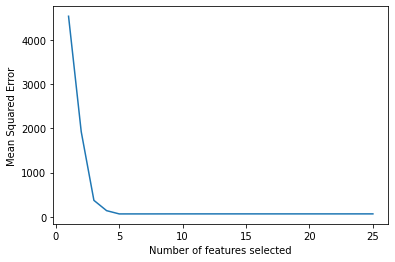

Optimal number of features : 5

For explainability, here is the model created by recursive feature selection and cross-validation:

$y = 0.198 + 8.671x_{3} + 40.568x_{8} + 53.000x_{19} + 68.886x_{22} + 15.516x_{25}$

RMSE: 8.068394

Recursive feature selection sometimes keeps certain features even though the coefficient is near zero.

Removing potential instances of near-zero coefficients:

$y = 0.198 + 8.671x_{3} + 40.568x_{8} + 53.000x_{19} + 68.886x_{22} + 15.516x_{25}$

RMSE: 8.068394

Normally, we would not have the signal that generated the data. However, since
    we do, we'll look at the function that generated the data as a point of comparison:

$y = 8.357x_{3} + 40.804x_{8} + 52.696x_{19} + 69.126x_{22} + 15.252x_{25}$

RMSE: 7.971791

Notably, even if we had discovered the exact signal that generated the data, our
    RMSE would still have been 7.971791 (which corresponds with the designated noise value of 8.00).

In [ ]:
# adapted from the RFECV entry in the scikit-learn API 

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

import numpy as np
import seaborn as sns
import pandas as pd


# initialize random state and regression parameters
random_state = np.random.RandomState(101)
n_features = 25
bias_data = 0
noise = 8

# create feature names -- these are generic feature names x_1, x_2, ..., x_25
feature_names = np.array([f'x_{{{idx+1}}}' for idx in range(n_features)])

def generate_model_function(beta0, betas, feature_names):
    if np.isclose(beta0, 0):
        model_function = f'$y = '
    else:
        model_function = f'$y = {beta0:.3f} + '

    # selected_features = np.argwhere(rfecv.support_).flatten()
    for beta, feature_name in zip(betas, feature_names):
        model_function += f'{beta:.3f}{feature_name} + '
        # model_function += f'{betas[idx]:.3f}{feature_names[feature_idx]} + '
    
    return model_function[:-3] + '$'


# Build a regression task using 5 informative features
X, y, coef_data = make_regression(n_samples=2000, 
                                  n_features=n_features, n_informative=5, 
                                  bias=bias_data, noise=noise,
                                  random_state=random_state, coef=True)

# split and sequester test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

linear = LinearRegression()

min_features_to_select = 1

# create the RFE object and compute a cross-validated score.
rfecv = RFECV(estimator=linear, step=1, 
              cv=RepeatedKFold(n_splits=10, n_repeats=5, random_state=random_state),
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_train,y_train)

# plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean Squared Error")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         -rfecv.grid_scores_)
plt.show()

display(md(f'Optimal number of features : {rfecv.n_features_}'))

# for explainability, report the trained model
display(md(f'For explainability, here is the model created by recursive feature selection and cross-validation:'))

selected_feature_names = feature_names[rfecv.support_]
display(md(generate_model_function(rfecv.estimator_.intercept_,
                                   rfecv.estimator_.coef_,
                                   selected_feature_names)))

# get metrics from test data
y_pred = rfecv.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
display(md(f'RMSE: {rmse:.6f}'))

print()

# remove near-zero coefficients, if applicable

# generate True/False filter array where True is model features that should be retained
# non_zero_coef is the length of the number of coefficients in the model
non_zero_coef = np.logical_not(np.isclose(rfecv.estimator_.coef_, 0))

# filter out model coefficients that are near zero
# selected_features_non_zero is a list of non-zero coefficients
selected_feature_coefs_non_zero = rfecv.estimator_.coef_[non_zero_coef]

# filter out model feature names by coefficients that are near zero
# selected_feature_names_non_zero is a list of the feature names having non-zero coefficients
selected_feature_names_non_zero = selected_feature_names[non_zero_coef]

display(md(generate_model_function(rfecv.estimator_.intercept_,
                                   selected_feature_coefs_non_zero,
                                   selected_feature_names_non_zero)))

y_pred = (np.dot(X_test[:,rfecv.support_][:,non_zero_coef], # X features in model downselected for non-zero coefficients
                selected_feature_coefs_non_zero)  # coefficients corresponding to X features
          + rfecv.estimator_.intercept_) # add bias

rmse = mean_squared_error(y_test, y_pred, squared=False)
display(md(f'RMSE: {rmse:.6f}'))

print()

display(md(f"""Normally, we would not have the signal that generated the data. However, since
    we do, we'll look at the function that generated the data as a point of comparison:"""))
# to satisfy our curiosity, report the model that produced the data
original_features = np.argwhere(coef_data!=0).flatten()
original_feature_names = feature_names[original_features]
original_coef = coef_data[original_features]
display(md(generate_model_function(bias_data, 
                                   original_coef,
                                   original_feature_names)))

y_pred = np.dot(X_test[:,original_features],original_coef)
rmse = mean_squared_error(y_test, y_pred, squared=False)
display(md(f'RMSE: {rmse:.6f}'))

display(md(f"""Notably, even if we had discovered the exact signal that generated the data, our
    RMSE would still have been {rmse:.6f} (which corresponds with the designated noise standard deviation value of {noise:.2f})."""))

